In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import (cross_val_predict, train_test_split, GridSearchCV,
                                     StratifiedKFold, KFold)
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score, log_loss)
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix


# Load and preprocess data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_file_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/train.csv'
test_file_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/test.csv'

df_train = pd.read_csv(train_file_path)

In [5]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
def preprocess_data(df):
    df = df.drop_duplicates()
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1}).astype('int8')
    df['Geography'] = df['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2}).astype('int8')
    df['Bal_Tenure'] = df['Balance'] * df['Tenure']
    df['Bal_Age'] = df['Balance'] * df['Age']
    df['Estimsal_Age'] = df['EstimatedSalary'] * df['Age']
    # df['Ten_NumOfProd'] = df['NumOfProducts']*df['Tenure']
    df.drop(['id', 'CustomerId', 'Surname'], inplace=True, axis=1)
    df.fillna(-1, inplace=True)
    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled


In [7]:
df_train_pp = preprocess_data(df_train)
df_train_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  float64
 2   Gender           165034 non-null  float64
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  float64
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  float64
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  float64
 11  Bal_Tenure       165034 non-null  float64
 12  Bal_Age          165034 non-null  float64
 13  Estimsal_Age     165034 non-null  float64
dtypes: float64(14)
memory usage: 17.6 MB


In [8]:
df_train_pp.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Bal_Tenure,Bal_Age,Estimsal_Age
0,0.079646,0.0,0.0,-0.4,-0.50,0.000000,0.0,0.0,0.0,0.788698,0.0,0.000000,0.000000,0.587500
1,-0.283186,0.0,0.0,-0.4,-1.00,0.000000,0.0,0.0,1.0,-0.850085,0.0,0.000000,0.000000,-0.841400
2,0.168142,0.0,0.0,0.3,1.25,0.000000,0.0,0.0,0.0,0.831134,0.0,0.000000,0.000000,1.049167
3,-0.690265,0.0,0.0,-0.3,-0.75,1.241313,-1.0,0.0,1.0,-0.414670,0.0,0.572559,1.155487,-0.434000
4,0.504425,2.0,0.0,-0.4,0.00,0.000000,0.0,0.0,1.0,-1.277766,0.0,0.000000,0.000000,-1.214306


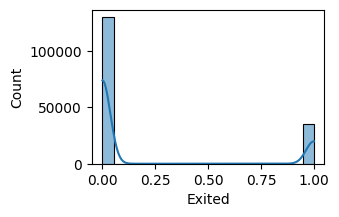

In [9]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(df_train_pp['Exited'], kde=True)
plt.show()

In [10]:
# oversample the minor class
y = df_train_pp['Exited']
X = df_train_pp.drop('Exited', axis=1)

ros = RandomOverSampler(sampling_strategy=1)
X_res_over, y_res_over = ros.fit_resample(X, y)
X_res_over.shape, y_res_over.shape, y.shape, X.shape

((260226, 13), (260226,), (165034,), (165034, 13))

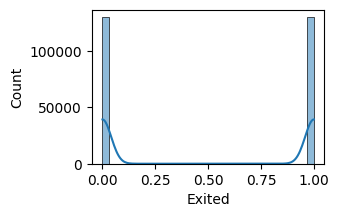

In [11]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(y_res_over, kde=True)
plt.show()

Now the dataset in balanced, we could proceed with train/test steps

In [12]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Bal_Tenure,Bal_Age,Estimsal_Age
0,0.079646,0.0,0.0,-0.4,-0.50,0.000000,0.0,0.0,0.0,0.788698,0.000000,0.000000,0.587500
1,-0.283186,0.0,0.0,-0.4,-1.00,0.000000,0.0,0.0,1.0,-0.850085,0.000000,0.000000,-0.841400
2,0.168142,0.0,0.0,0.3,1.25,0.000000,0.0,0.0,0.0,0.831134,0.000000,0.000000,1.049167
3,-0.690265,0.0,0.0,-0.3,-0.75,1.241313,-1.0,0.0,1.0,-0.414670,0.572559,1.155487,-0.434000
4,0.504425,2.0,0.0,-0.4,0.00,0.000000,0.0,0.0,1.0,-1.277766,0.000000,0.000000,-1.214306


# Train

In [13]:
y = y_res_over
X = X_res_over

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208180, 13), (52046, 13), (208180,), (52046,))

## K-Nearest Neighbors

In [14]:
from sklearn.model_selection import cross_val_score

# K-Nearest Neighbors model
KNN = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed

# StratifiedKFold for cross-validation with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute ROC AUC scores
KNN_cross_val = cross_val_score(KNN, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

# Print the average cross-validated ROC AUC score
print(f"CV score of KNN is {KNN_cross_val.mean()}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


CV score of KNN is 0.8969319838593546
2024-04-12 08:28:15


##  Histogram Gradient Boosting Classifier

In [15]:
# X_train and y_train are your training features and target variables
Hist_GB = HistGradientBoostingClassifier(max_iter=700, learning_rate=0.1, min_samples_leaf=20, max_depth=6, random_state=42)

# Create KFold for cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute ROC AUC scores
Hist_GB_cross_val = cross_val_score(Hist_GB, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

# Print the average cross-validated ROC AUC score
print(f"CV score of Hist GB is {Hist_GB_cross_val.mean()}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

CV score of Hist GB is 0.9122796029210425
2024-04-12 08:29:25


## Cat boost

In [16]:
# define catboost classifier
CAT = CatBoostClassifier(iterations=1000, verbose=100, random_seed=42)
CAT.fit(X_train, y_train)

# perform crossvalidation
roc_auc_score = cross_val_score(CAT, X_test, y_test, cv=5, scoring='roc_auc').mean()

print("CV score of CatBoost is:", roc_auc_score)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Learning rate set to 0.100672
0:	learn: 0.6348515	total: 91.7ms	remaining: 1m 31s
100:	learn: 0.4117405	total: 4.2s	remaining: 37.4s
200:	learn: 0.4039799	total: 8.19s	remaining: 32.6s
300:	learn: 0.3973645	total: 13.9s	remaining: 32.2s
400:	learn: 0.3914921	total: 17.9s	remaining: 26.8s
500:	learn: 0.3861213	total: 22.1s	remaining: 22s
600:	learn: 0.3812282	total: 28s	remaining: 18.6s
700:	learn: 0.3765982	total: 32.1s	remaining: 13.7s
800:	learn: 0.3722168	total: 36.2s	remaining: 9s
900:	learn: 0.3680456	total: 42.1s	remaining: 4.62s
999:	learn: 0.3640526	total: 46.2s	remaining: 0us
Learning rate set to 0.050635
0:	learn: 0.6637786	total: 12.6ms	remaining: 12.6s
100:	learn: 0.4196706	total: 1.13s	remaining: 10s
200:	learn: 0.4103345	total: 2.21s	remaining: 8.78s
300:	learn: 0.4012822	total: 3.28s	remaining: 7.63s
400:	learn: 0.3934793	total: 5.62s	remaining: 8.39s
500:	learn: 0.3863749	total: 7.33s	remaining: 7.3s
600:	learn: 0.3798989	total: 8.41s	remaining: 5.58s
700:	learn: 0.3740

In [17]:
# cb_model = CatBoostClassifier(
#     auto_class_weights='Balanced',
#     eval_metric='AUC',
#     learning_rate=0.04,
#     reg_lambda=1,  # L2 regularization
#     depth=7,  # Reduce tree depth
#     verbose=10,
#     random_seed=42,
#     iterations=100
# )

# # Train the model using the specified categorical features
# cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

# Ensemble the models

In [27]:
# Assume models KNN, Hist_GB, and CAT are already trained and imported
models = [('KNN', KNN), ('Hist_GB', Hist_GB), ('CAT', CAT)]

# Initialize the VotingClassifier with soft voting
ensemble_model = VotingClassifier(estimators=models, voting='soft')

# cross_val_predict to get the predicted probabilities for each fold
ensemble_preds = cross_val_predict(ensemble_model, X_train, y_train, cv=skf, method='predict_proba')

# Calculate the ROC AUC score for the ensemble
ensemble_roc_auc = roc_auc_score(y_train, ensemble_preds[:, 1])
print(f"ROC AUC score of the ensemble is: {ensemble_roc_auc}")

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Learning rate set to 0.091522
0:	learn: 0.6401541	total: 32.7ms	remaining: 32.7s
100:	learn: 0.4110690	total: 3.34s	remaining: 29.8s
200:	learn: 0.4032650	total: 7.83s	remaining: 31.1s
300:	learn: 0.3966605	total: 11.7s	remaining: 27.1s
400:	learn: 0.3909028	total: 15s	remaining: 22.3s
500:	learn: 0.3856162	total: 18.4s	remaining: 18.3s
600:	learn: 0.3807871	total: 23.5s	remaining: 15.6s
700:	learn: 0.3760479	total: 26.8s	remaining: 11.4s
800:	learn: 0.3715034	total: 30.2s	remaining: 7.49s
900:	learn: 0.3671533	total: 34.9s	remaining: 3.83s
999:	learn: 0.3631539	total: 38.5s	remaining: 0us
Learning rate set to 0.091522
0:	learn: 0.6392708	total: 33.5ms	remaining: 33.5s
100:	learn: 0.4108435	total: 3.33s	remaining: 29.6s
200:	learn: 0.4032500	total: 6.58s	remaining: 26.2s
300:	learn: 0.3965680	total: 11.6s	remaining: 27s
400:	learn: 0.3906167	total: 15s	remaining: 22.5s
500:	learn: 0.3853081	total: 18.4s	remaining: 18.3s
600:	learn: 0.3803471	total: 21.6s	remaining: 14.4s
700:	learn: 0.

In [28]:
# Fit the ensemble model on training data
ensemble_model.fit(X_train, y_train)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Learning rate set to 0.100672
0:	learn: 0.6348515	total: 44.5ms	remaining: 44.5s
100:	learn: 0.4117405	total: 4.21s	remaining: 37.5s
200:	learn: 0.4039799	total: 10.2s	remaining: 40.4s
300:	learn: 0.3973645	total: 14.4s	remaining: 33.5s
400:	learn: 0.3914921	total: 18.4s	remaining: 27.6s
500:	learn: 0.3861213	total: 24.3s	remaining: 24.2s
600:	learn: 0.3812282	total: 28.5s	remaining: 18.9s
700:	learn: 0.3765982	total: 33s	remaining: 14.1s
800:	learn: 0.3722168	total: 38.5s	remaining: 9.57s
900:	learn: 0.3680456	total: 42.7s	remaining: 4.69s
999:	learn: 0.3640526	total: 47.9s	remaining: 0us


VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('Hist_GB',
                              HistGradientBoostingClassifier(max_depth=6,
                                                             max_iter=700,
                                                             random_state=42)),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x7905e59aba00>)],
                 voting='soft')

In [31]:
# lables on the test set
y_pred = ensemble_model.predict(X_test)

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85     26008
         1.0       0.84      0.87      0.85     26038

    accuracy                           0.85     52046
   macro avg       0.85      0.85      0.85     52046
weighted avg       0.85      0.85      0.85     52046

Confusion Matrix:
[[21543  4465]
 [ 3400 22638]]


    True Negatives (TN): 21,543 were correctly predicted as class 0
    False Positives (FP): 4,465 were incorrectly predicted as class 1 when they were actually class 0
    False Negatives (FN): 3,400 were incorrectly predicted as class 0 when they were actually class 1
    True Positives (TP): 22,638 were correctly predicted as class 1

    The model shows a good balance between precision and recall for both classes

    The slightly higher recall for class 1 suggests the model is slightly
    better at identifying all relevant instances of class 1 than it is for class 0

    Depending on the specific business task and the costs of false positives vs. false negatives, we might want to adjust
    the decision threshold or explore model tuning to optimize for one metric over another.

# Testing

In [34]:
# load test data
df_test = pd.read_csv(test_file_path)

In [35]:
# predict probabilities for the test set
df_test_pp = preprocess_data(df_test)

In [36]:
X_test = df_test_pp
y_pred_proba_test = ensemble_model.predict_proba(X_test)[:, 1]

# Submition

In [37]:
submission_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/sample_submission.csv'

sample = pd.read_csv(submission_path)

print(sample.head())
print(sample.shape)


       id  Exited
0  165034     0.5
1  165035     0.5
2  165036     0.5
3  165037     0.5
4  165038     0.5
(110023, 2)


In [38]:
sample['Exited'] = y_pred_proba_test

# save to submissions
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/Churn_bank_exited/subm_churn_bank_ensemble.csv', index=False)

sample['Exited']

0         0.052999
1         0.963564
2         0.043264
3         0.588678
4         0.534269
            ...   
110018    0.169270
110019    0.183757
110020    0.057319
110021    0.385004
110022    0.329848
Name: Exited, Length: 110023, dtype: float64

the results using ensemble model on kaggle

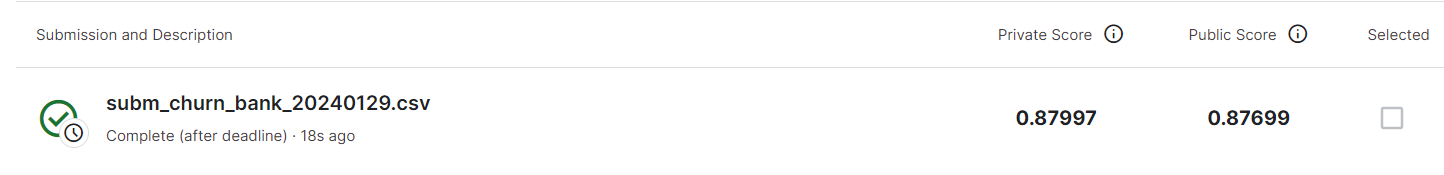

general rank 2158/3632

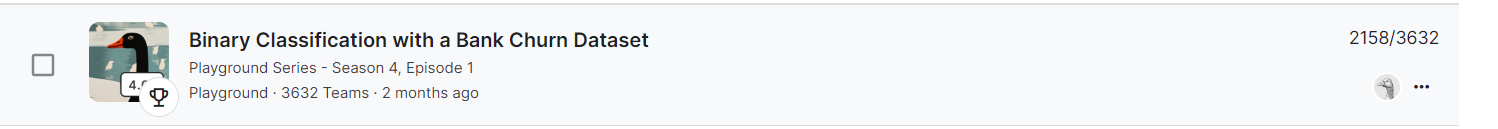